<a href="https://colab.research.google.com/github/mshahzaib101/temperature-forecasting-with-RNN/blob/main/temperature_forecasting_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir jena_climate
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2020-10-20 03:35:58--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.41.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.41.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.4MB/s    in 0.7s    

2020-10-20 03:35:59 (18.4 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [ ]:
!unzip -u "/content/jena_climate_2009_2016.csv.zip" -d "/content/jena_climate"

Archive:  /content/jena_climate_2009_2016.csv.zip
  inflating: /content/jena_climate/jena_climate_2009_2016.csv  


## Getting Data

In [ ]:
import os

data_dir = '/content/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

In [ ]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [ ]:
len(lines)

420551

In [ ]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [ ]:
float_data.shape

(420551, 14)

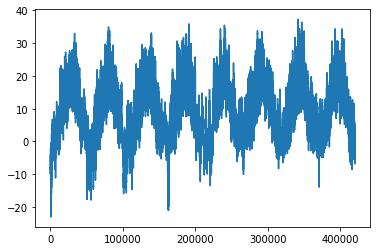

In [ ]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

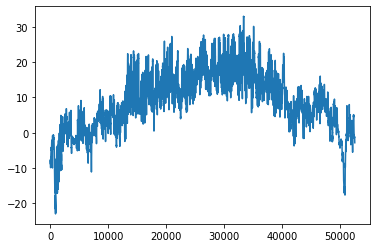

In [ ]:
plt.plot(range(52560), temp[:52560])

## Preparing the Data

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [ ]:
float_data.shape

(420551, 14)

In [ ]:
float_data[0]

array([ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
       -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
        2.12375056, -0.72950452, -0.78067973, -0.27613603])

In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
np.random.randint(1,4,size=3)

array([1, 2, 1])

In [ ]:

lookback

1440

In [ ]:
float_data.shape[-1]

14

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=20,
validation_data=val_gen,
validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 0.5104

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## GRU layer

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=20,
validation_data=val_gen,
validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 87s 174ms/step - loss: 0.3095 - val_loss: 0.2699
Epoch 2/20
500/500 [==============================] - 86s 172ms/step - loss: 0.2871 - val_loss: 0.2710
Epoch 3/20
500/500 [==============================] - 93s 185ms/step - loss: 0.2792 - val_loss: 0.2632
Epoch 4/20
500/500 [==============================] - 86s 173ms/step - loss: 0.2728 - val_loss: 0.2645
Epoch 5/20
500/500 [==============================] - 88s 176ms/step - loss: 0.2699 - val_loss: 0.2626
Epoch 6/20
500/500 [==============================] - 87s 175ms/step - loss: 0.2651 - val_loss: 0.2663
Epoch 7/20
500/500 [==============================] - 86s 173ms/step - loss: 0.2611 - val_loss: 0.2629
Epoch 8/20
500/500 [==============================] - 87s 174ms/step - loss: 0.2571 - val_loss: 0.2644
Epoch 9/20
500/500 [==============================] - 87s 174ms/step - loss: 0.2531 - val_loss: 0.2680
Epoch 10/20
500/500 [==============================] - 88s 176ms/step - l

## using dropout and stacking RNN 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


model = Sequential()
model.add(layers.GRU(32,
dropout=0.1,
recurrent_dropout=0.5,
return_sequences=True,
input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
dropout=0.1,
recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=40,
validation_data=val_gen,
validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
500/500 [==============================] - 357s 714ms/step - loss: 0.3214 - val_loss: 0.2803
Epoch 2/40
500/500 [==============================] - 354s 707ms/step - loss: 0.3023 - val_loss: 0.2778
Epoch 3/40
500/500 [==============================] - 357s 714ms/step - loss: 0.2924 - val_loss: 0.2663
Epoch 4/40
500/500 [==============================] - 354s 707ms/step - loss: 0.2838 - val_loss: 0.2699
Epoch 5/40
500/500 [==============================] - 357s 714ms/step - loss: 0.2764 - val_loss: 0.2709
Epoch 6/40
500/500 [==============================] - 354s 708ms/step - loss: 0.2703 - val_loss: 0.2716
Epoch 7/40
500/500 [==============================] - 358s 715ms/step - loss: 0.2652 - val_loss: 0.2793
Epoch 8/40
500/500 [==============================] - 352s 705ms/step - loss: 0.2598 - val_loss: 0.2794
Epoch 9/40
500/500 [==============================] - 352s 704ms/step - loss: 0.2563 - val_l